# Objetivo
Predecir si el paciente va a sufrir un accidente cerebro vascular.

# Contexto comercial
Según la OMS (Organización Mundial de la Salud) la segunda causa de muerte más frecuente en el mundo es el accidente cerebro vascular, responsable del 11% de las muertes aproximadamente. Entonces, se nececesita predecir si el paciente es propenso a sufrir un ACV para así tomar medidas al respecto para poder prevenirlo.

# Problema comercial
Para poder predecir si el paciente va a sufrir de un accidente cerebro vascular se debe analizar cuáles son los factores que influyen en la desencadenación del mismo. Es así como, sabiendo las particularidades del paciente que hacen que esté sea propenso o no a sufrir un ACV, se idea el modelo de predicción.

# Contexto analítico
Para poder desarrollar el modelo se cuenta con diferentes variables como; la edad, el género y diferentes condiciones de salud del paciente.

Cada fila del dataset almacena la información de un paciente, las variables que incluye son:

* Id: identificador único
* Género: femenino, masculino u otro.
* Hipertensión: 0 si el paciente no tiene hipertensión, 1 si el paciente si tiene.
* Cardiopatía: 0 si el paciente no presenta ninguna cardiopatía, 1 si el paciente si presenta.
* Alguna vez casado: Si o no.
* Tipo de trabajo: Privado, cuenta propia, empleado estatal, menor de edad o nunca trabajo.
* Tipo de residente: Urbano o Rural
* Nivel de glucosa en sangre promedio.
* Índice de masa corporal (IMC).
* Estado de fumador: Fumaba anteriormente, nunca fumó, fuma o no se sabe.
* ACV: 1 si el paciente tuvo un ACV, 0 si el paciente no tuvo.


In [1]:
import numpy as np
import pandas as pd
import requests
from io import StringIO

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

url='https://drive.google.com/file/d/1avIUmiYaXRb5xyxYmMSRPItSxh72w4Ur/view?usp=sharing'

file_id = url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url2 = requests.get(dwn_url).text
csv_raw = StringIO(url2)
df = pd.read_csv(csv_raw)
print(df.head())

# Librerías para arboles de decision 
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Librerias para regresión logística
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer


      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


Se comienza con un análisis exploratorio de las variables, para poder tener una vista general de los datos.

Nuestra estructura ya esta diseñada en el dataset.
## Variable Target 
Binaria: Indica 1 si la persona sufrió un ACV y 0 si no sufrió un ACV.
## Features
Las demás columnas presentes en el dataset.

# Primera exploración

In [2]:
df['stroke'] = df['stroke'].replace([0, 1], ['No', 'Si'])
df['hypertension'] = df['hypertension'].replace([0, 1], ['No', 'Si'])
df['heart_disease'] = df['heart_disease'].replace([0, 1], ['No', 'Si'])
df['ever_married']= df['ever_married'].replace(['Yes', 'No'], ['Si', 'No'])
df['work_type']= df['work_type'].replace(["Private", "Self-employed", "Govt_jov","children", "Never_worked", ], ['Privado', 'Cuenta propia', 'Empleado estatal', 'Menor de edad', 'Nunca trabajo'])
df['Residence_type']= df['Residence_type'].replace(['Urban', 'Rural'], ['Urbano', 'Rural'])
df['smoking_status']= df['smoking_status'].replace(["formerly smoked", "never smoked", "smokes", "Unknown"], ['Fumaba anteriormente', 'Nunca fumó', 'Fuma', 'No se sabe'])
df['gender']= df['gender'].replace(['Male', 'Female','Other'], ['Hombre', 'Mujer','Otro'])
print(df.head())


      id  gender   age hypertension heart_disease ever_married      work_type  \
0   9046  Hombre  67.0           No            Si           Si        Privado   
1  51676   Mujer  61.0           No            No           Si  Cuenta propia   
2  31112  Hombre  80.0           No            Si           Si        Privado   
3  60182   Mujer  49.0           No            No           Si        Privado   
4   1665   Mujer  79.0           Si            No           Si  Cuenta propia   

  Residence_type  avg_glucose_level   bmi        smoking_status stroke  
0         Urbano             228.69  36.6  Fumaba anteriormente     Si  
1          Rural             202.21   NaN            Nunca fumó     Si  
2          Rural             105.92  32.5            Nunca fumó     Si  
3         Urbano             171.23  34.4                  Fuma     Si  
4          Rural             174.12  24.0            Nunca fumó     Si  


In [3]:
print(df.describe())

                 id          age  avg_glucose_level          bmi
count   5110.000000  5110.000000        5110.000000  4909.000000
mean   36517.829354    43.226614         106.147677    28.893237
std    21161.721625    22.612647          45.283560     7.854067
min       67.000000     0.080000          55.120000    10.300000
25%    17741.250000    25.000000          77.245000    23.500000
50%    36932.000000    45.000000          91.885000    28.100000
75%    54682.000000    61.000000         114.090000    33.100000
max    72940.000000    82.000000         271.740000    97.600000


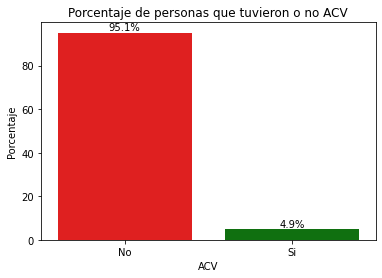

In [4]:
# Contar la cantidad de cada categoría
conteo = df['stroke'].value_counts(normalize=True) * 100  # Normalizar para obtener porcentajes
conteo_df = conteo.reset_index()
conteo_df.columns = ['ACV', 'Porcentaje']

# Crear gráfico de barras
sns.barplot(x='ACV', y='Porcentaje', data=conteo_df, palette=['red', 'green'])

# Agregar título y etiquetas
plt.title('Porcentaje de personas que tuvieron o no ACV')
plt.ylabel('Porcentaje')

# Mostrar los valores porcentuales en las barras
for i, v in enumerate(conteo_df['Porcentaje']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

# Mostrar gráfico
plt.show()

#plt.figure()
#sns.countplot(data = df,
 #             x = 'stroke',palette=['#8093F1','#72DDF7'])
#plt.xlabel("Ocurrencia de ACV")
#plt.ylabel("Frecuencia absoluta")
#plt.title("Gráfico N°1: Cantidad de personas que pasaron o no por un ACV")




In [5]:
frec =df['stroke'].value_counts()
porc = df['stroke'].value_counts(normalize=True)

res = pd.concat([frec, porc], axis=1)\
        .set_axis(['Frecuencia absoluta', 'Porcentaje'], axis=1, inplace=False)

print(res)

   Frecuencia absoluta  Porcentaje
0                 4861    0.951272
1                  249    0.048728


En el gráfico 1 se observa que la proporción de pacientes en el dataset que vivenciaron un ACV fueron muy pocas, aproximadamente solo el 5% del total de pacientes presentes en el dataset sufrieron un ACV.

[Text(0.5, 0, 'Nivel medio de glucosa en sangre'),
 Text(0, 0.5, 'Frecuencia absoluta')]

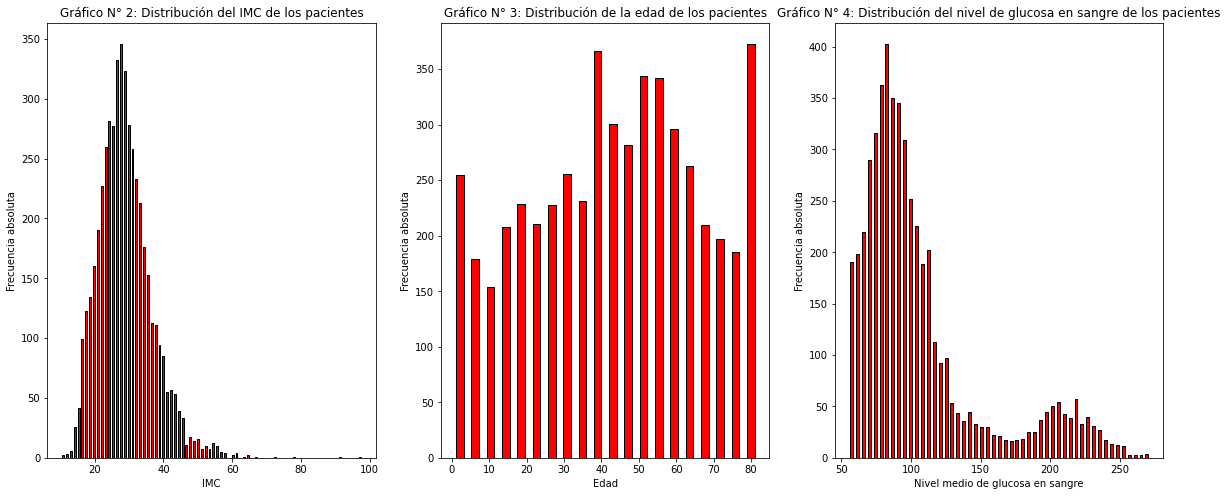

In [5]:
#GRÁFICOS CON SEABORN

fig=plt.figure(figsize=(20,8),facecolor='white')
gs=fig.add_gridspec(1,3)
ax=[None for i in range(3)]
ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])
ax[2]=fig.add_subplot(gs[0,2])



sns.histplot(x=df['bmi'],ax=ax[0], color='red',alpha=1,zorder=2,linewidth=1,edgecolor='black',shrink=0.5).set(title = 'Gráfico N° 2: Distribución del IMC de los pacientes')
ax[0].set(xlabel='IMC', ylabel='Frecuencia absoluta')
sns.histplot(x=df['age'],ax=ax[1], color='red', alpha=1,zorder=2,linewidth=1,edgecolor='black',shrink=0.5).set(title = 'Gráfico N° 3: Distribución de la edad de los pacientes')
ax[1].set(xlabel='Edad', ylabel='Frecuencia absoluta')
sns.histplot(x=df['avg_glucose_level'],ax=ax[2], color='red', alpha=1,zorder=2,linewidth=1,edgecolor='black',shrink=0.5).set(title = 'Gráfico N° 4: Distribución del nivel de glucosa en sangre de los pacientes')
ax[2].set(xlabel='Nivel medio de glucosa en sangre', ylabel='Frecuencia absoluta')

In [6]:
df[["bmi","age","avg_glucose_level"]].agg(['mean','median','std'])



,bmi,age,avg_glucose_level
mean,28.893237,43.226614,106.147677
median,28.100000,45.000000,91.885000
std,7.854067,22.612647,45.283560


Se realizan estos 3 gráficos en conjunto para analizar la distribución de las 3 variables númericas continuas presentes en el dataset. Se puede observar en el Gráfico 2 que el IMC de los pacientes se concentra alrededor de 25 y 30 como indica también la tabla (media y mediana aproximadamente iguales a 28), mientras que en el gráfico 4 vemos que la mayor parte de la gente tiene un nivel de glucosa en sangre entre 75 y 100. En cambio, en el Gráfico 3 se observa que la cantidad de personas en las diferentes edades es equitativa.
En la tabla se observa la misma información que en los gráficos, se puede agregar que el promedio de la edad de los pacientes en el dataset es de 45 años con desvíos de 23 años aproximadamente respecto de su media, el IMC posee menos desvío respecto a su media que las otras dos variables analizadas.

Text(0.5, 1.0, 'Gráfico N°5: Boxplot de IMC según si el paciente tuvo un ACV o no')

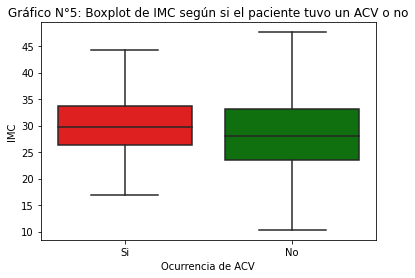

In [7]:
#GRÁFICO CON SEAPLOT

plt.figure()
sns.boxplot(data = df,
            x = 'stroke',
            y = 'bmi',
            showfliers = False,
            palette=['red','green'])
plt.xlabel("Ocurrencia de ACV")
plt.ylabel("IMC")
plt.title("Gráfico N°5: Boxplot de IMC según si el paciente tuvo un ACV o no")

En el Gráfico 5 se visualiza que la mediana del IMC es levemente mayor para los que tuvieron un ACV que para los que no, pero los valores de IMC para los que tuvieron un ACV están más concentrados, es decir, tienen menor variabilidad que para los que no presentaron un ACV.

Text(0.5, 1.0, 'Gráfico N°6: Boxplot del nivel de glucosa en sangre según si el paciente tuvo un ACV o no')

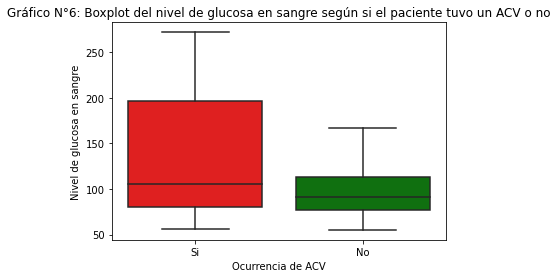

In [8]:
plt.figure()
sns.boxplot(data = df,
            x = 'stroke',
            y = 'avg_glucose_level',
            showfliers = False,
            palette=['red','green'])
plt.xlabel("Ocurrencia de ACV")
plt.ylabel("Nivel de glucosa en sangre")
plt.title("Gráfico N°6: Boxplot del nivel de glucosa en sangre según si el paciente tuvo un ACV o no")

En el Gráfico 6 se observa nuevamente que la mediana del nivel de glucosa en sangre suele ser levemente mayor para los pacientes que presentaron un ACV, pero estos pacientes también presentaron niveles más altos de glucosa en sangre que los que no presentaron un ACV, teniendo un mayor desvío respecto a la mediana.

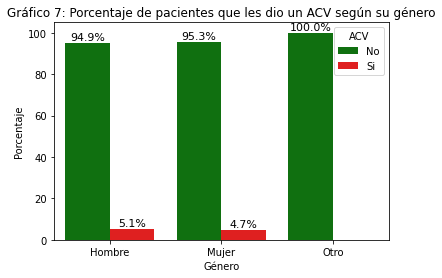

In [16]:
# Contar la frecuencia de cada combinación (normalizando para obtener proporciones)
df_relativo = df.groupby(['gender', 'stroke']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index(name='Porcentaje')

# Crear gráfico usando las frecuencias relativas
ax = sns.barplot(data=df_relativo, 
                 x='gender', 
                 y='Porcentaje', 
                 hue='stroke', 
                 palette={'Si': 'red', 'No': 'green'})

# Agregar título y etiquetas
plt.title('Gráfico 7: Porcentaje de pacientes que les dio un ACV según su género')
plt.xlabel('Género')
plt.ylabel('Porcentaje')

# Agregar las etiquetas de porcentaje sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=11, color='black', 
                xytext=(0, 3), 
                textcoords='offset points')

# Personalizar la leyenda
plt.legend(title='ACV', loc='upper right')

# Mostrar el gráfico
plt.show()


Se puede observar en el Gráfico 7 que el género no parece ser un factor de riesgo para un ACV, ya que el porcentaje de pacientes hombres y mujeres es el mismo tanto para los que tuvieron un ACV como para los que no.

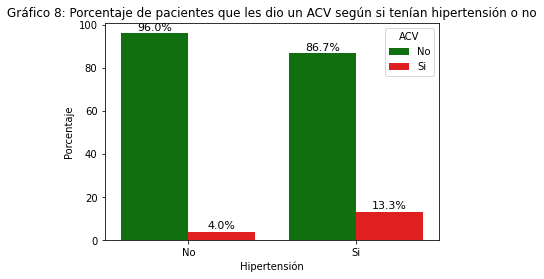

In [15]:
# Contar la frecuencia de cada combinación (normalizando para obtener proporciones)
df_relativo = df.groupby(['hypertension', 'stroke']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index(name='Porcentaje')

# Crear gráfico usando las proporciones
ax = sns.barplot(data=df_relativo, 
                 x='hypertension', 
                 y='Porcentaje', 
                 hue='stroke', 
                 palette={'Si': 'red', 'No': 'green'})  # Cambiar colores para 'Si' y 'No'

# Agregar título y etiquetas
plt.title('Gráfico 8: Porcentaje de pacientes que les dio un ACV según si tenían hipertensión o no')
plt.xlabel('Hipertensión')
plt.ylabel('Porcentaje')

# Agregar etiquetas de porcentaje sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=11, color='black', 
                xytext=(0, 3), 
                textcoords='offset points')

# Personalizar la leyenda
plt.legend(title='ACV', loc='upper right')

# Mostrar el gráfico
plt.show()


Se puede observar que dentro de los pacientes que tienen hipertensión el porcentaje de sufrir un ACV es un poco mayor que para los que no tienen hipertensión, esto puede indicar que la hipertensión es un factor de riesgo para un ACV.

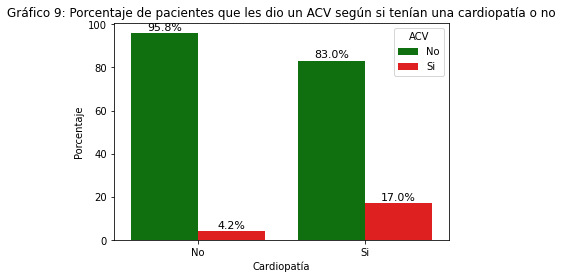

In [17]:
# Contar la frecuencia de cada combinación (normalizando para obtener proporciones)
df_relativo = df.groupby(['heart_disease', 'stroke']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index(name='Porcentaje')

# Crear gráfico usando las proporciones
ax = sns.barplot(data=df_relativo, 
                 x='heart_disease', 
                 y='Porcentaje', 
                 hue='stroke', 
                 palette={'Si': 'red', 'No': 'green'})  # Cambiar colores para 'Si' y 'No'

# Agregar título y etiquetas
plt.title('Gráfico 9: Porcentaje de pacientes que les dio un ACV según si tenían una cardiopatía o no')
plt.xlabel('Cardiopatía')
plt.ylabel('Porcentaje')

# Agregar etiquetas de porcentaje sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=11, color='black', 
                xytext=(0, 3), 
                textcoords='offset points')

# Mostrar la leyenda de forma automática, asociada a los colores
plt.legend(title='ACV', loc='upper right')

# Mostrar el gráfico
plt.show()

Se observa el mismo comportamiento que en el caso de hipertensión, parece ser que los que sufren alguna cardiopatía tienen más chances de sufrir un ACV.

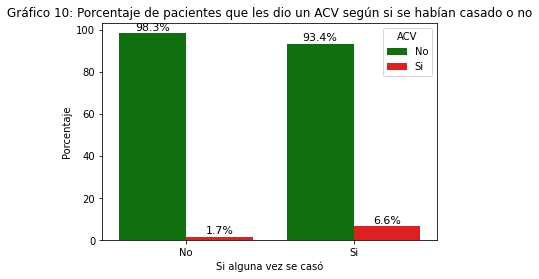

In [18]:
# Contar la frecuencia de cada combinación (normalizando para obtener proporciones)
df_relativo = df.groupby(['ever_married', 'stroke']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index(name='Porcentaje')

# Crear gráfico usando las proporciones
ax = sns.barplot(data=df_relativo, 
                 x='ever_married', 
                 y='Porcentaje', 
                 hue='stroke', 
                 palette={'Si': 'red', 'No': 'green'})  # Cambiar colores para 'Si' y 'No'

# Agregar título y etiquetas
plt.title('Gráfico 10: Porcentaje de pacientes que les dio un ACV según si se habían casado o no')
plt.xlabel('Si alguna vez se casó')
plt.ylabel('Porcentaje')

# Agregar etiquetas de porcentaje sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=11, color='black', 
                xytext=(0, 3), 
                textcoords='offset points')

# Mostrar la leyenda de forma automática, asociada a los colores
plt.legend(title='ACV', loc='upper right')

# Mostrar el gráfico
plt.show()

In [86]:
(df.groupby('ever_married')['stroke']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
)

,ever_married,stroke,percent
0,No,No,98.349459
1,No,Si,1.650541
2,Si,No,93.438712
3,Si,Si,6.561288


La diferencia de porcentajes en la tabla anterior es muy leve para los que alguna vez se casaron que para los que no, se podría sospechar que este no es un factor que afecte a la ocurrencia de un ACV.

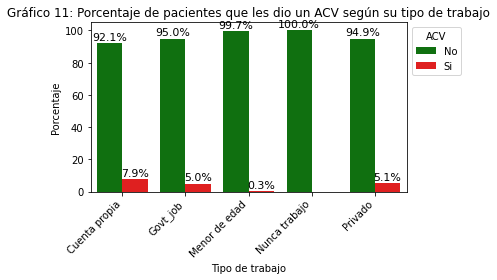

In [20]:
# Contar la frecuencia de cada combinación (normalizando para obtener proporciones)
df_relativo = df.groupby(['work_type', 'stroke']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index(name='Porcentaje')

# Crear gráfico usando las proporciones
ax = sns.barplot(data=df_relativo, 
                 x='work_type', 
                 y='Porcentaje', 
                 hue='stroke', 
                 palette={'Si': 'red', 'No': 'green'})  # Cambiar colores para 'Si' y 'No'

# Agregar título y etiquetas
plt.title('Gráfico 11: Porcentaje de pacientes que les dio un ACV según su tipo de trabajo')
plt.xlabel('Tipo de trabajo')
plt.ylabel('Porcentaje')

# Agregar etiquetas de porcentaje sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=11, color='black', 
                xytext=(0, 3), 
                textcoords='offset points')

# Rotar etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Ajustar la posición de la leyenda
plt.legend(title='ACV', loc='upper left', bbox_to_anchor=(1, 1))

# Ajustar los márgenes para dar espacio a la leyenda
plt.tight_layout()

# Mostrar el gráfico
plt.show()

La diferencia en las distintas categorías de tipo de trabajo para los pacientes que sufrieron un ACV como para los que no difieren muy poco, como en el caso anterior, se podría llegar a pensar que el tipo de trabajo no es un factor de riesgo.

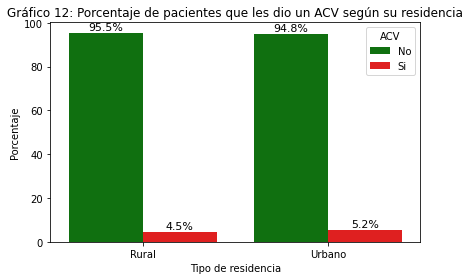

In [21]:
# Contar la frecuencia de cada combinación (normalizando para obtener proporciones)
df_relativo = df.groupby(['Residence_type', 'stroke']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index(name='Porcentaje')

# Crear gráfico usando las proporciones
ax = sns.barplot(data=df_relativo, 
                 x='Residence_type', 
                 y='Porcentaje', 
                 hue='stroke', 
                 palette={'Si': 'red', 'No': 'green'})  # Cambiar colores para 'Si' y 'No'

# Agregar título y etiquetas
plt.title('Gráfico 12: Porcentaje de pacientes que les dio un ACV según su residencia')
plt.xlabel('Tipo de residencia')
plt.ylabel('Porcentaje')

# Agregar etiquetas de porcentaje sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=11, color='black', 
                xytext=(0, 3), 
                textcoords='offset points')

# Mostrar la leyenda de forma automática, asociada a los colores
plt.legend(title='ACV')

# Ajustar los márgenes para dar espacio a la leyenda
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Ocurre lo mismo que en los dos casos anteriores.

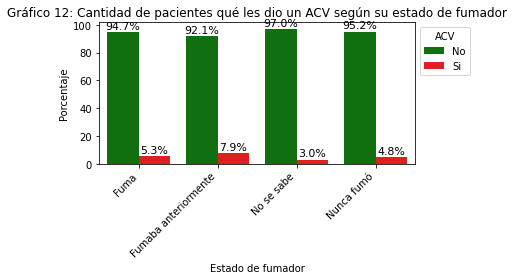

In [22]:
# Contar la frecuencia de cada combinación (normalizando para obtener proporciones)
df_relativo = df.groupby(['smoking_status', 'stroke']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index(name='Porcentaje')

# Crear gráfico usando las proporciones
ax = sns.barplot(data=df_relativo, 
                 x='smoking_status', 
                 y='Porcentaje', 
                 hue='stroke', 
                 palette={'Si': 'red', 'No': 'green'})  # Cambiar colores para 'Si' y 'No'

# Agregar título y etiquetas
plt.title('Gráfico 12: Cantidad de pacientes qué les dio un ACV según su estado de fumador')
plt.xlabel('Estado de fumador')
plt.ylabel('Porcentaje')

# Agregar etiquetas de porcentaje sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=11, color='black', 
                xytext=(0, 3), 
                textcoords='offset points')

# Rotar etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Ajustar la posición de la leyenda
plt.legend(title='ACV', loc='upper left', bbox_to_anchor=(1, 1))

# Ajustar los márgenes para dar espacio a la leyenda
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [95]:
(df.groupby('stroke')['smoking_status']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
)

,stroke,smoking_status,percent
0,No,Nunca fumó,37.070562
1,No,No se sabe,30.796132
2,No,Fumaba anteriormente,16.766098
3,No,Fuma,15.367208
4,Si,Nunca fumó,36.144578
5,Si,Fumaba anteriormente,28.112450
6,Si,No se sabe,18.875502
7,Si,Fuma,16.867470


En esta última tabla se puede observar que de los pacientes que sufrieron un ACV, hay un mayor porcentaje para los que fumaban anteriormente comparado con los que no sufrieron un ACV, pudiendo ser el ACV la causa de haber dejado de fumar, como una suposición.

# Análisis de posibles valores faltantes.

Se va a verificar si el dataset cuenta con presencia de valores ausentes.

In [4]:
# SE REVISA SI HAY VALORES FALTANTES EN EL DATAFRAME
filas_con_na = df[df.isna().any(axis=1)]

# Se imprime las filas con valores faltantes
print(filas_con_na)

         id  gender   age hypertension heart_disease ever_married  \
1     51676   Mujer  61.0           No            No           Si   
8     27419   Mujer  59.0           No            No           Si   
13     8213  Hombre  78.0           No            Si           Si   
19    25226  Hombre  57.0           No            Si           No   
27    61843  Hombre  58.0           No            No           Si   
...     ...     ...   ...          ...           ...          ...   
5039  42007  Hombre  41.0           No            No           No   
5048  28788  Hombre  40.0           No            No           Si   
5093  32235   Mujer  45.0           Si            No           Si   
5099   7293  Hombre  40.0           No            No           Si   
5105  18234   Mujer  80.0           Si            No           Si   

          work_type Residence_type  avg_glucose_level  bmi  \
1     Cuenta propia          Rural             202.21  NaN   
8           Privado          Rural             

Se puede observar que hay 201 filas con valores faltantes y al parecer todas, o la mayoría se debe a la variable correspondiente al índice de masa muscular. Se decide reemplazar estos valores por la mediana del índice de masa muscular.

In [10]:
mediana = df['bmi'].median()
df['bmi'].fillna(mediana, inplace=True)


In [ ]:
Se chequea si quedó algún valor nulo en otra variable.

In [11]:
# SE REVISA SI HAY VALORES FALTANTES EN EL DATAFRAME
filas_con_na = df[df.isna().any(axis=1)]

# Se imprime las filas con valores faltantes
print(filas_con_na)

Empty DataFrame
Columns: [id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status, stroke]
Index: []


Se verifica que los valores nulos solo correspondían a la variable Índice de masa muscular.

# Feature selection

# Algoritmo de clasificación

# Métricas para validar el modelo

# Conclusiones